# Recommendation Systems

### Objective
To make a recommendation system that recommends at least 5 new products based on the user's habits.

### Context
Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites. For this case study, we are using Amazon Reviews of electronics
dataset.

### Import the libraries 

In [1]:
import warnings
import numpy as np
import scipy.sparse
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.externals import joblib
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline 
pd.options.display.float_format = "{:.4f}".format

/home/machine/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Reading Dataset

In [2]:
# Reading the dataset and giving the column names

columns = ['user_id', 'product_id', 'ratings','timestamp']
original_df = pd.read_csv('ratings_Electronics.csv', names=columns)

original_df.head(10)

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0000,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0000,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0000,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0000,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0000,1395532800
9,A89DO69P0XZ27,0511189877,5.0000,1395446400


In [3]:
# Get information about column data types and non-null values
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   ratings     float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
# Get number of rows and columns
rows, columns = original_df.shape
print('No. of rows: ', rows)
print('No. of columns: ', columns)

No. of rows:  7824482
No. of columns:  4


In [5]:
#Taking subset of the dataset
subset_df = original_df.iloc[:780000,0:]

In [6]:
# Get number of missing values in each column
subset_df.isnull().sum().sort_values() 

user_id       0
product_id    0
ratings       0
timestamp     0
dtype: int64

In [7]:
#Five-point Summary
subset_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,780000.0000,3.9818,1.3960,1.0000,3.0000,5.0000,5.0000,5.0000
timestamp,780000.0000,1242460233.9692,116475219.3992,912729600.0000,1154390400.0000,1247011200.0000,1356652800.0000,1406073600.0000


#### Observations

- Original dataframe has 7824482 rows and 4 columns. 
- Since the data is very big and due to memory constraints, we are considering only the first 50000 rows and all columns as subset reduced dataset. 
- No NULL/empty values in the dataset as of yet.
- Attributes 'user_id' and 'product_id' are string and attributes 'timestamp' and 'ratings' are numerical in nature.
- User ratings rage from 1 (minimum) to 5 (maximum).

### Univariate Analysis

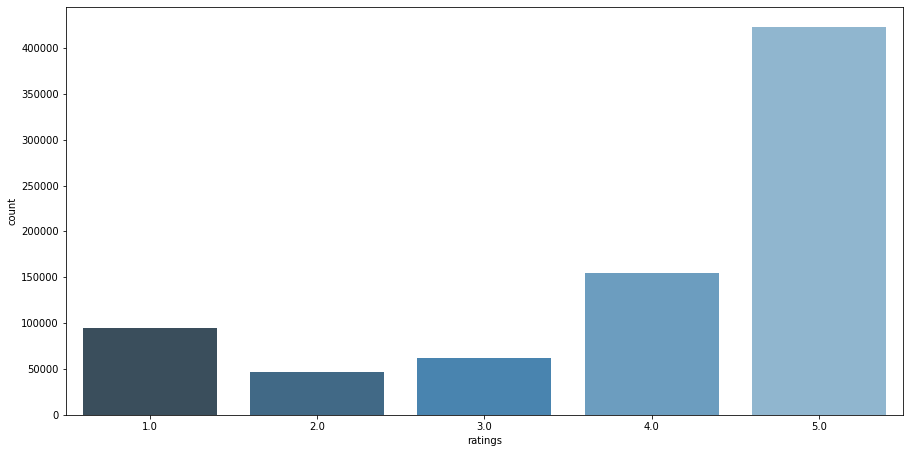

In [8]:
# Checking how 'ratings' are distributed
plt.figure(figsize=(15, 7.5))
sns.countplot(x="ratings", data=subset_df, palette="Blues_d");

#### Observations

Here we have visualized distribution for 'ratings' attribute, and the following observations were made:
- Ratings are highly skewed towards left.
- Most of the customer reviews are good reviews with a rating of 5.

## Taking subset of the dataset to make it less sparse/ denser

In [9]:
#Check the top 10 users based on ratings
subset_df.groupby('user_id').size().sort_values(ascending = False)[:10]

user_id
A5JLAU2ARJ0BO     384
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    163
A6FIAB28IS79      113
AT6CZDCP4TRGA     112
AKT8TGIT6VVZ5     108
A11D1KHM7DVOQK    106
A2B7BUH8834Y6M     98
A2AEZQ3DGBBLPR     81
A2R6RA8FRBS608     79
dtype: int64

In [10]:
subset_df.drop('timestamp', axis=1, inplace=True)
reviews_num = subset_df.user_id.value_counts()
final_df = subset_df[subset_df.user_id.isin(reviews_num[reviews_num >= 50].index)]

print('No. of users who have rated 25 or more items:', len(final_df))
print('No. of unique products:', final_df['product_id'].nunique())
print('No. of unique users:', final_df['user_id'].nunique())

No. of users who have rated 25 or more items: 2547
No. of unique products: 2204
No. of unique users: 27


### Ratings analysis in final dataset

In [11]:
#Constructing the pivot table
final_ratings_matrix = final_df.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
final_ratings_matrix.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP50AY,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A12DLJESJKM1OQ,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A149RNR5RH19YY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A1F9Z42CFF9IAY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A1FR68QH6Z4YZM,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [12]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
density = (given_num_of_ratings/possible_num_of_ratings)*100

print('Given no. of rratings: ', given_num_of_ratings)
print('Possible no. of ratings: ', possible_num_of_ratings)
print ('Density: {:4.2f}%'.format(density))

Given no. of rratings:  2547
Possible no. of ratings:  59508
Density: 4.28%


#### Observations

- To make the dataset less sparse, only the data of users who has given 25 or more number of ratings were taken into account.
- Dropped 'timestamp' attribute in the reduced_df as it doesn't add any significant impact to the dataset.
- The density value of the matrix shows that this is a sparse matrix.

### Splitting the dataset

In [13]:
#Splitting the dataset into train and test datasets
train_data, test_data = train_test_split(final_df, test_size = 0.3, random_state=0)
train_data.head()

,user_id,product_id,ratings
241445,A2B7BUH8834Y6M,B0000899ZA,3.0000
392204,A5JLAU2ARJ0BO,B0001G0FGW,5.0000
162243,A203OCQQ12MAVT,B000068O4J,5.0000
175462,A149RNR5RH19YY,B00006B9HP,4.0000
631979,AGHZXQL9F94T9,B0007XO79U,2.0000


## Building Popularity Recommder model

In [14]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head(10)

,product_id,score
0,1400532655,1
1,B000001OL6,1
2,B000001OMN,1
3,B00000J061,1
4,B00000J1E6,1
5,B00000J1EP,1
6,B00000J1US,1
7,B00000J1UU,1
8,B00000J3NG,1
9,B00000J434,1


In [15]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,product_id,score,rank
81,B00004SB92,5,1.0000
710,B00007KDVI,4,2.0000
980,B0000AKVHF,4,3.0000
185,B00004Z5M1,3,4.0000
275,B00005AW1H,3,5.0000


In [16]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [17]:
find_recom = [4, 6, 8]   # This list is user choice.
for i in find_recom:
    print("User_id: %d recommends the following: \n" %(i))
    print(recommend(i))    
    print("\n") 

User_id: 4 recommends the following: 

     user_id  product_id  score   rank
81         4  B00004SB92      5 1.0000
710        4  B00007KDVI      4 2.0000
980        4  B0000AKVHF      4 3.0000
185        4  B00004Z5M1      3 4.0000
275        4  B00005AW1H      3 5.0000


User_id: 6 recommends the following: 

     user_id  product_id  score   rank
81         6  B00004SB92      5 1.0000
710        6  B00007KDVI      4 2.0000
980        6  B0000AKVHF      4 3.0000
185        6  B00004Z5M1      3 4.0000
275        6  B00005AW1H      3 5.0000


User_id: 8 recommends the following: 

     user_id  product_id  score   rank
81         8  B00004SB92      5 1.0000
710        8  B00007KDVI      4 2.0000
980        8  B0000AKVHF      4 3.0000
185        8  B00004Z5M1      3 4.0000
275        8  B00005AW1H      3 5.0000




#### Observations
- Since, it is a Popularity recommender model, all users have recommended the same list of products. 
- Here, since we predicted the products based on the popularity, it is not personalized to particular user. 


##  Building Collaborative Filtering recommender model.

In [18]:
collab_filter_df = pd.concat([train_data, test_data]).reset_index()
collab_filter_df.head(10)

,index,user_id,product_id,ratings
0,241445,A2B7BUH8834Y6M,B0000899ZA,3.0000
1,392204,A5JLAU2ARJ0BO,B0001G0FGW,5.0000
2,162243,A203OCQQ12MAVT,B000068O4J,5.0000
3,175462,A149RNR5RH19YY,B00006B9HP,4.0000
4,631979,AGHZXQL9F94T9,B0007XO79U,2.0000
5,81821,A1RPTVW5VEOSI,B000051TIV,2.0000
6,82878,AKT8TGIT6VVZ5,B0000520IV,5.0000
7,71859,A2BGZ52M908MJY,B00004ZCC2,5.0000
8,240399,A12DLJESJKM1OQ,B000087LIG,5.0000
9,701132,A1F9Z42CFF9IAY,B000A3WS84,4.0000


#### User Based Collaborative Filtering model

In [19]:
# Matrix with row per 'user' and column per 'product' 
pivot_df = collab_filter_df.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
pivot_df.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP50AY,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A12DLJESJKM1OQ,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A149RNR5RH19YY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A1F9Z42CFF9IAY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A1FR68QH6Z4YZM,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [20]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
A12DLJESJKM1OQ,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
A149RNR5RH19YY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2
A1F9Z42CFF9IAY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3
A1FR68QH6Z4YZM,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4


In [21]:
# Actual ratings given by users
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP50AY,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


#### Observations

- Since this is a sparse matrix, we will use Singular value decomposition.

### Singular Value Decomposition

In [22]:
# Constructing diagonal array in SVD
U, sigma, Vt = svds(pivot_df, k = 10)
sigma = np.diag(sigma)

In [23]:
# Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP50AY,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA
0,0.0108,0.0076,0.3414,0.0194,0.0204,0.0011,0.0618,0.0015,0.3414,0.0097,...,0.0291,-0.0164,0.0339,0.0556,0.1473,0.0703,0.0563,0.4268,0.0563,-0.0102
1,-0.0088,-0.1524,-0.4166,-0.0124,0.0068,0.1012,-0.2335,-0.0305,-0.4166,-0.0062,...,-0.0186,-0.0434,0.0114,-0.0063,-0.4040,0.2147,0.1718,-0.5208,0.1718,-0.0952
2,0.0038,-0.0014,0.0200,0.0024,0.1644,0.0000,0.0426,-0.0003,0.0200,0.0012,...,0.0037,-0.0078,0.2741,0.2817,0.0394,0.0180,0.0144,0.0250,0.0144,-0.0053
3,0.0051,-0.0262,0.0610,0.0074,0.1205,0.0414,0.0031,-0.0052,0.0610,0.0037,...,0.0112,0.0526,0.2008,0.2109,0.2502,0.0671,0.0537,0.0762,0.0537,0.0406
4,0.0144,-0.0194,0.0700,0.0066,0.0521,0.0170,0.0017,-0.0039,0.0700,0.0033,...,0.0099,-0.0039,0.0868,0.1155,0.1197,0.0628,0.0502,0.0874,0.0502,0.7638


In [24]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [25]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00008OE5G               0.0000            0.8327
B00008K4BD               0.0000            0.8134
B0000UA3MA               0.0000            0.6535
B000067VKY               0.0000            0.6496
B000087LII               0.0000            0.6496


In [26]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B0000EWNWE               0.0000            0.6450
B0000E6S0Y               0.0000            0.6450
B00022TN9A               0.0000            0.6311
B0002ZPJZY               0.0000            0.6168
B0009Q0I3E               0.0000            0.6168


In [27]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00008OE6I               0.0000            0.2595
B00005137P               0.0000            0.2560
B0007OW51Q               0.0000            0.2519
B00008OE5G               0.0000            0.2456
B0001U6RNI               0.0000            0.2440


#### Observations

- Since, it is a Collaborative recommender model, all the three users are have recommended different products - based on their past behaviour.
- Now we would have to evaluate both the models.

### Evaluation of Collabrative recommendation model 

In [28]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

product_id
1400532655   0.0370
B000000O48   0.1852
B000001OL6   0.1481
B000001OMN   0.0741
B00000J05A   0.1111
dtype: float64

In [29]:
# Predicted ratings 
preds_df.head()

product_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BP50AY,B000BP8AMY,B000BPNUCY,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA
0,0.0108,0.0076,0.3414,0.0194,0.0204,0.0011,0.0618,0.0015,0.3414,0.0097,...,0.0291,-0.0164,0.0339,0.0556,0.1473,0.0703,0.0563,0.4268,0.0563,-0.0102
1,-0.0088,-0.1524,-0.4166,-0.0124,0.0068,0.1012,-0.2335,-0.0305,-0.4166,-0.0062,...,-0.0186,-0.0434,0.0114,-0.0063,-0.4040,0.2147,0.1718,-0.5208,0.1718,-0.0952
2,0.0038,-0.0014,0.0200,0.0024,0.1644,0.0000,0.0426,-0.0003,0.0200,0.0012,...,0.0037,-0.0078,0.2741,0.2817,0.0394,0.0180,0.0144,0.0250,0.0144,-0.0053
3,0.0051,-0.0262,0.0610,0.0074,0.1205,0.0414,0.0031,-0.0052,0.0610,0.0037,...,0.0112,0.0526,0.2008,0.2109,0.2502,0.0671,0.0537,0.0762,0.0537,0.0406
4,0.0144,-0.0194,0.0700,0.0066,0.0521,0.0170,0.0017,-0.0039,0.0700,0.0033,...,0.0099,-0.0039,0.0868,0.1155,0.1197,0.0628,0.0502,0.0874,0.0502,0.7638


In [30]:
# Average PREDICTED rating for each item
preds_df.mean().head()

product_id
1400532655    0.0393
B000000O48   -0.0050
B000001OL6    0.1914
B000001OMN    0.0140
B00000J05A    0.1352
dtype: float64

In [31]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
1400532655,0.0370,0.0393,0
B000000O48,0.1852,-0.0050,1
B000001OL6,0.1481,0.1914,2
B000001OMN,0.0741,0.0140,3
B00000J05A,0.1111,0.1352,4


In [32]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.08131 



### Getting top - K (K = 5) recommendations. 

In [33]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 10
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B00005T3DP               0.0000            0.3574
B0000696HN               0.0000            0.2887
B00005KAMT               0.0000            0.2887
B00006LHO7               0.0000            0.2887
B000065V15               0.0000            0.2887


## Summarising insights.

- The Popularity-based recommender system is a non-personalized recommender system and are based on frequecy counts, which may be not suitable to the user. 

- As we can see for ourselves that for user ids 4, 6 & 8, the Popularity based model has recommended the same set of 5 products. however, inthe Collaborative Filtering based model, it has recommended different list of products based on the user's past purchase history.